# JLS bibliometry

# Preparation

In [ ]:
# Uncomment and run once
# if you use vanilla python:
#   !pip install py2neo python-dotenv pandas pyvis
# OR if you use anaconda:
#   !conda install -c conda-forge py2neo python-dotenv
#   !conda install panda pyvis
# for table of contents support, see https://github.com/ipython-contrib/jupyter_contrib_nbextensions

Import the required libraries and setup needed objects:

In [1]:
# config
from dotenv import dotenv_values
config = {**dotenv_values()}

# https://py2neo.org/v4/
from py2neo import Graph, Node, Relationship

graph = Graph(config['NEO4J_URL'], name="jls")
import scripts.pyvis


## Author network (Cownie/Bradney)

In [ ]:
query = """
MATCH path=(a1:Author)-[:CREATOR_OF]->(w1:Work)-[c:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.family = "cownie" OR a2.family = "cownie" or a1.family = "bradney" OR a2.family = "bradney"
    and ((w1)-[:PUBLISHED_IN]->(:Venue {id:"j law soc"}) or (w2)-[:PUBLISHED_IN]->(:Venue {id:"j law soc"}))
WITH a1, a2, count(c) as citations
WHERE citations >= 4
WITH collect(a1) + collect(a2) as authorNetwork, citations
UNWIND authorNetwork as authors
MATCH p2=(authors)-[:CREATOR_OF]->(:Work)-[c:CITES]->(:Work)<-[:CREATOR_OF]-(citingAuthor:Author)
WHERE citingAuthor in authorNetwork
WITH authors, citingAuthor, count(c) as citations
where authors.family <> "no_author" and citingAuthor.family <> "no_author" and authors <> citingAuthor
RETURN authors as source_node,
    apoc.create.vRelationship(authors, 'CITES', {value: citations}, citingAuthor) as rel,
    citingAuthor as target_node
"""
scripts.pyvis.draw(graph, query)

In [ ]:
## Top 10 cited authors of each decade and the most influential citing authors

In [ ]:
query = """
// find the 10 most cited authors for all works with the id 'j law soc' , who have also published in this venue (globalMostCited)
MATCH (a:Author)-[:CREATOR_OF]->(w:Work)<-[:CITES]-(w2:Work)-[:PUBLISHED_IN]->(v:Venue {id: 'j law soc'})
where a.family <> "no_author"
WITH a, COUNT(w2) AS citationCount
ORDER BY citationCount DESC
LIMIT 1000
WITH collect(a) AS globalMostCited

// for all of the works published in the venue during that period (i.e., having a corresponding `year` property), determine the 10 most-cited authors (localMostCited)
MATCH (a2:Author)-[:CREATOR_OF]->(w3:Work)<-[:CITES]-(w4:Work)-[:PUBLISHED_IN]->(v2:Venue {id: 'j law soc'})
WHERE w3.year >= $year_start AND w3.year <= $year_end and a2.family <> "no_author"
WITH a2, COUNT(w4) AS localCitationCount, globalMostCited
ORDER BY localCitationCount DESC
LIMIT 10
WITH collect(a2) AS localMostCited, globalMostCited

// unroll both collections to a list of nodes
UNWIND globalMostCited AS gmc
UNWIND localMostCited AS lmc

// find citations between these nodes
MATCH path = (gmc)-[:CREATOR_OF]->(:Work)-[:CITES]->(:Work)<-[:CREATOR_OF]-(lmc)
WITH gmc, lmc, COUNT(path) AS pathCount

// create virtual relationships
CALL apoc.create.vRelationship(gmc, 'CITES', {value: pathCount}, lmc) YIELD rel
RETURN gmc, lmc, rel

"""
start_year = 1974
end_year = 2023
for i in range(5):
    decade_start = start_year + (i * 10)
    decade_end = decade_start + 9
    if decade_end > end_year:
        decade_end = end_year
    scripts.pyvis.draw(graph, query, year_start=decade_start, year_end=decade_end, height="1000px", file=f"figure/jls-most-cited-{decade_start}-{decade_end}.html", do_display=False)


## Co-Citation network


In [ ]:
query = """
MATCH (a1:Author)-[:CREATOR_OF]->(:Work)<-[:CITES]-(w:Work)-[:CITES]->(:Work)<-[:CREATOR_OF]-(a2:Author)
WITH a1, a2, COUNT(w) as co_citations
WHERE id(a1) < id(a2) AND co_citations >= 100
and a1.family <> "no_author" and a2.family <> "no_author"
CALL apoc.create.vRelationship(a1, "IS_COCITED_WITH", {count: co_citations}, a2)
YIELD rel
RETURN a1, rel, a2
ORDER BY rel.count DESC
"""
scripts.pyvis.draw(graph, query, file="figure/jls-co-citation-network.html", height="800px")

### Most-cited authors, table

In [2]:
query = """
match (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
where citedAuthor.family <> "no_author" and citedAuthor.display_name <> ""
return citedAuthor.display_name as `Author`, count(*) as `Citation count`
order by `Citation count` desc
limit 30
"""
from scripts.utils import get_graph
graph = get_graph("jls2")
df = graph.run(query).to_data_frame()
df

,Author,Citation count
0,"foucault, m.",233
1,"luhmann, n.",226
2,"teubner, g.",220
3,"habermas, j.",155
4,"braithwaite, j.",152
5,"nelken, d.",137
6,"twining, w.",129
7,"abel, r.",128
8,"cotterrell, r.",125
9,"weber, m.",123


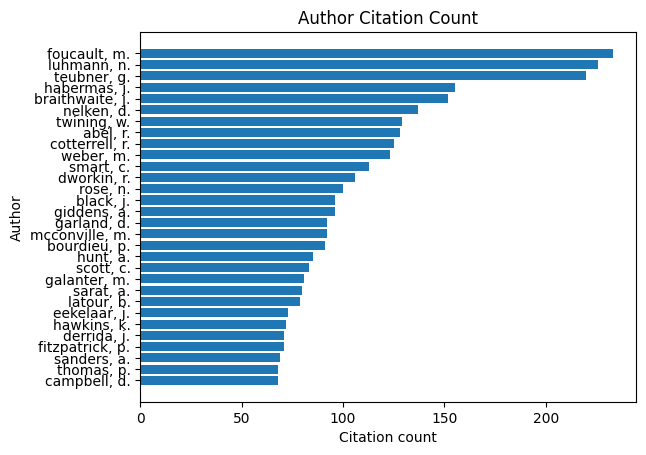

In [4]:
import matplotlib.pyplot as plt
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Author'], df['Citation count'])
plt.xlabel('Citation count')
plt.ylabel('Author')
plt.title('Author Citation Count')
plt.savefig("docs/jls-most-cited-authors.png", bbox_inches="tight")
plt.show()

## Most-cited authors, over time

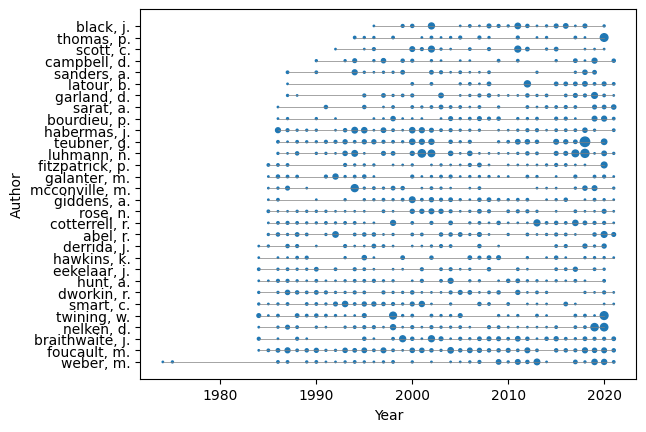

In [5]:
query = """
match (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
where citedAuthor.family <> "no_author" and citedAuthor.display_name <> ""
with citedAuthor, count(*) as citationCount
order by citationCount desc
limit 30
match (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor)
RETURN citedAuthor.display_name as author, citingWork.year as year, count(*) as count
order by year
"""
from scripts.utils import get_graph
from scripts.occurrence_by_year_scatter import plot_by_year
graph = get_graph("jls")
data = graph.run(query).to_data_frame()
plot_by_year(data, dep_col="author", dep_label="Author")

## Most-cited journals

In [1]:
query = """
match (citingWork:Work)-[r:CITES]->(:Work)-[:PUBLISHED_IN]-(citedVenue:Venue)
where exists((citingWork)-[:PUBLISHED_IN]->(:Venue {id:"j law soc"}))
return citedVenue.name as `Journal name`, count(r) as `Citation count`
order by `Citation count` desc
limit 20
"""
from scripts.utils import get_graph
graph = get_graph("jls2")
df = graph.run(query).to_data_frame()
df

,Journal name,Citation count
0,journal of law & society,991
1,modern law review,498
2,law & society review,417
3,social & legal studies,292
4,law rev,278
5,harvard law rev,251
6,yale law j,224
7,legal studies,223
8,criminal law review,205
9,public law,183


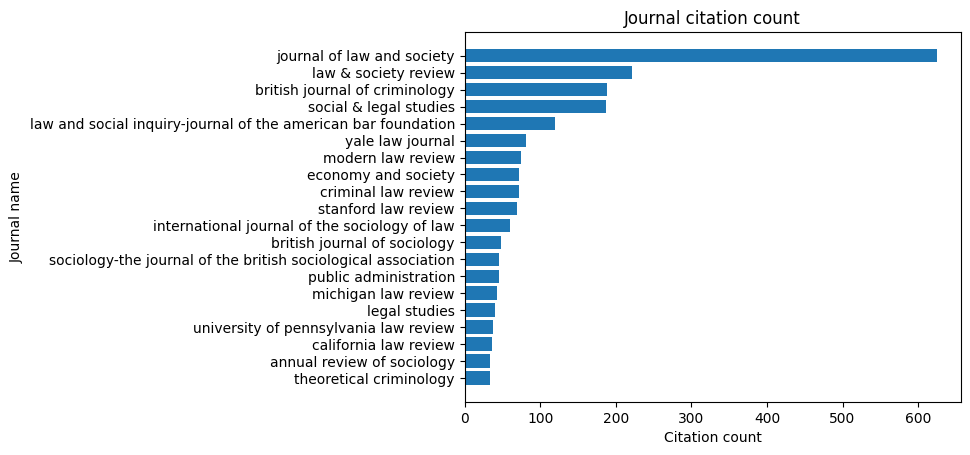

In [30]:
import matplotlib.pyplot as plt
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Journal name'], df['Citation count'])
plt.xlabel('Citation count')
plt.ylabel('Journal name')
plt.title('Journal citation count')
plt.savefig("docs/jls-most-cited-journals.png", bbox_inches="tight")
plt.show()

## WOS journal network

In [27]:
query = """
match (citingWork:Work)-[r:CITES]->(:Work)-[:PUBLISHED_IN]-(citedVenue:Venue)
where exists((citingWork)-[:PUBLISHED_IN]->(:Venue {name:"JOURNAL OF LAW AND SOCIETY"}))
return toLower(citedVenue.name) as `Journal name`, count(r) as `Citation count`
order by `Citation count` desc
limit 20
"""
from scripts.utils import get_graph

graph = get_graph("jls-journal-network")
df = graph.run(query).to_data_frame()
df

,Journal name,Citation count
0,journal of law and society,625
1,law & society review,221
2,british journal of criminology,188
3,social & legal studies,187
4,law and social inquiry-journal of the american...,119
5,yale law journal,81
6,modern law review,74
7,criminal law review,72
8,economy and society,72
9,stanford law review,69


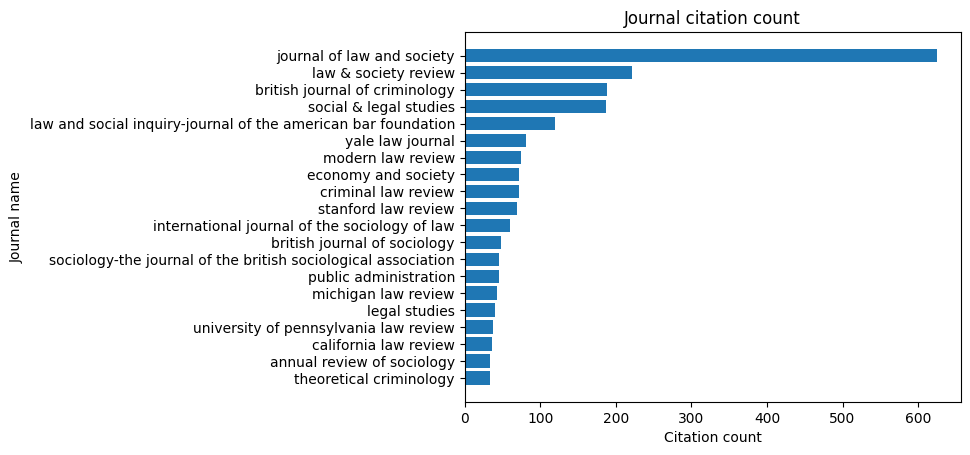

In [31]:
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Journal name'], df['Citation count'])
plt.xlabel('Citation count')
plt.ylabel('Journal name')
plt.title('Journal citation count')
plt.savefig("docs/jls-most-cited-journals-wos.png", bbox_inches="tight")
plt.show()